In [1]:
import tensorflow as tf
import numpy as np
import sys
from datetime import datetime
from functools import partial
from utils import *

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

MODEL_PATH = "models/autoencoder/"

In [3]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

input_img = Input(shape=(28, 28, 1))                                    # 28 x 28 x 1

x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)    # 28 x 28 x 8
x_M1 = MaxPooling2D((2, 2), padding='same')(x)                          # 14 x 14 x 8
x_C2 = Conv2D(4, (3, 3), activation='relu', padding='same')(x_M1)       # 14 x 14 x 4
encoded = MaxPooling2D((2, 2), padding='same')(x_C2)                    # 7 x 7 x 4 = (28 x 28 x 1) * 0.25 (and each feature map has the same replicated weights so it decreases again the complexity)

x_C3 = Conv2D(4, (3, 3), activation='relu', padding='same')(encoded)    # 7 x 7 x 4
x_U1 = UpSampling2D((2, 2))(x_C3)                                       # 14 x 14 x 4
x_C4 = Conv2D(8, (3, 3), activation='relu', padding='same')(x_U1)      # 14 x 14 x 8
x_U2 = UpSampling2D((2, 2))(x_C4)                                       # 28 x 28 x 8
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x_U2) # 28 x 28 x 1

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [4]:
x.shape

TensorShape([Dimension(None), Dimension(28), Dimension(28), Dimension(8)])

In [5]:
x_M1.shape

TensorShape([Dimension(None), Dimension(14), Dimension(14), Dimension(8)])

In [6]:
x_C2.shape

TensorShape([Dimension(None), Dimension(14), Dimension(14), Dimension(4)])

In [7]:
encoded.shape

TensorShape([Dimension(None), Dimension(7), Dimension(7), Dimension(4)])

In [8]:
x_C3.shape

TensorShape([Dimension(None), Dimension(7), Dimension(7), Dimension(4)])

In [9]:
x_U1.shape

TensorShape([Dimension(None), Dimension(14), Dimension(14), Dimension(4)])

In [10]:
x_C4.shape

TensorShape([Dimension(None), Dimension(14), Dimension(14), Dimension(8)])

In [11]:
x_U2.shape

TensorShape([Dimension(None), Dimension(28), Dimension(28), Dimension(8)])

In [12]:
decoded.shape

TensorShape([Dimension(None), Dimension(28), Dimension(28), Dimension(1)])

In [13]:
from tensorflow.keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [ ]:
from tensorflow.keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=100,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
 7900/60000 [==>...........................] - ETA: 1:03 - loss: 0.1355

In [15]:
# saving model
autoencoder.save(MODEL_PATH + 'autoencoder.h5')

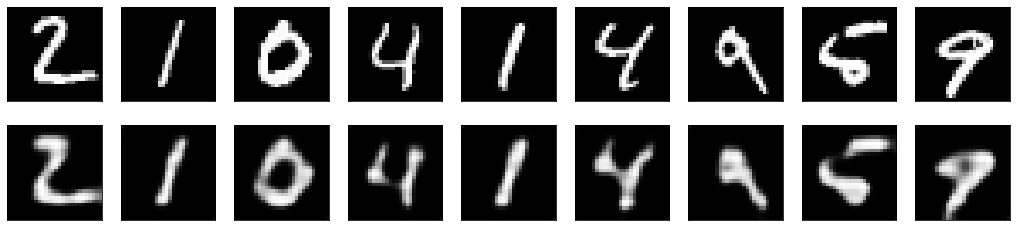

In [16]:
decoded_imgs = autoencoder.predict(x_test[:10])

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Restore model used for unsupervised pre-training

In [30]:
pretrained_autoencoder = keras.models.load_model(MODEL_PATH + 'autoencoder.h5')
pretrained_autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 8)           0   

### adding layers at the end of the pretrained model

In [31]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

In [32]:
x = pretrained_autoencoder.output
# Adding a fully connected layers
x = Dense(1024, activation='relu')(x)
x = Dense(200, activation='relu')(x)
# Adding a fully connected layer for the 10 classes 0 to 9
predictions = Dense(10, activation='softmax')(x)

### freezing model

In [33]:
model = Model(inputs=pretrained_autoencoder.input, outputs=predictions)

# freeze all layers of the pre-trained model
# we will only train the Dense layers added in "model"
for layer in pretrained_autoencoder.layers:
    layer.trainable = False

# compile the model with adam optimizer and sparse_categorical_crossentropy loss function
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])